In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Чтение данных

In [2]:
clients = pd.read_csv('clustering.csv')

In [3]:
clients.head(5)

,client_id,gender,age,membership_duration,visit_count,fitness_category_count,total_visit_cost,fitness_category_crossfit,fitness_category_goboxing,fitness_category_АКАДЕМИЯ_ИЛЬИНА,fitness_category_ВОСТОЧНЫЕ_ЕДИНОБОРСТВА,fitness_category_ГРУППОВЫЕ_ПРОГРАММЫ,fitness_category_ДЕТСКИЙ_КЛУБ,fitness_category_ТРЕНАЖЕРНЫЙ_ЗАЛ,fitness_category_СТУДИЯ_ЙОГИ_ШАКТИ,fitness_category_ВОДНЫЕ_ПРОГРАММЫ
0,1,0,26,1293.75,30,2,18235500.0,0,0,0,0,0,0,1,0,1
1,2,0,6,1393.75,32,2,3542400.0,0,0,0,0,0,1,0,0,1
2,4,0,25,656.25,60,2,66214500.0,0,1,0,0,0,0,1,0,0
3,5,0,34,1627.00,12,1,11931600.0,0,0,0,0,0,0,1,0,0
4,6,0,17,717.25,12,1,11931600.0,0,0,0,0,0,0,1,0,0


In [4]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 16 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   client_id                                4020 non-null   int64  
 1   gender                                   4020 non-null   int64  
 2   age                                      4020 non-null   int64  
 3   membership_duration                      4020 non-null   float64
 4   visit_count                              4020 non-null   int64  
 5   fitness_category_count                   4020 non-null   int64  
 6   total_visit_cost                         4020 non-null   float64
 7   fitness_category_crossfit                4020 non-null   int64  
 8   fitness_category_goboxing                4020 non-null   int64  
 9   fitness_category_АКАДЕМИЯ_ИЛЬИНА         4020 non-null   int64  
 10  fitness_category_ВОСТОЧНЫЕ_ЕДИНОБОРСТВА  4020 no

#### Определение признаков

In [20]:
features = ['visit_count', 'membership_duration', 'fitness_category_count', 'total_visit_cost', 'age']


#### Кодирование категориального признака "gender"

In [21]:
encoder = OneHotEncoder(drop='first')  # drop='first' используется для избежания мультиколлинеарности
gender_encoded = encoder.fit_transform(clients[['gender']]).toarray()
gender_encoded_df = pd.DataFrame(gender_encoded, columns=encoder.get_feature_names_out(['gender']))

#### Добавление закодированных признаков к основным данным

In [22]:
X = pd.concat([clients[features[:-1]], gender_encoded_df], axis=1)

KeyError: "['fitness_category_CROSSFIT', 'fitness_category_GOBOXING'] not in index"

#### Разделение данных на обучающую и тестовую выборки

In [8]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

#### Масштабирование данных

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

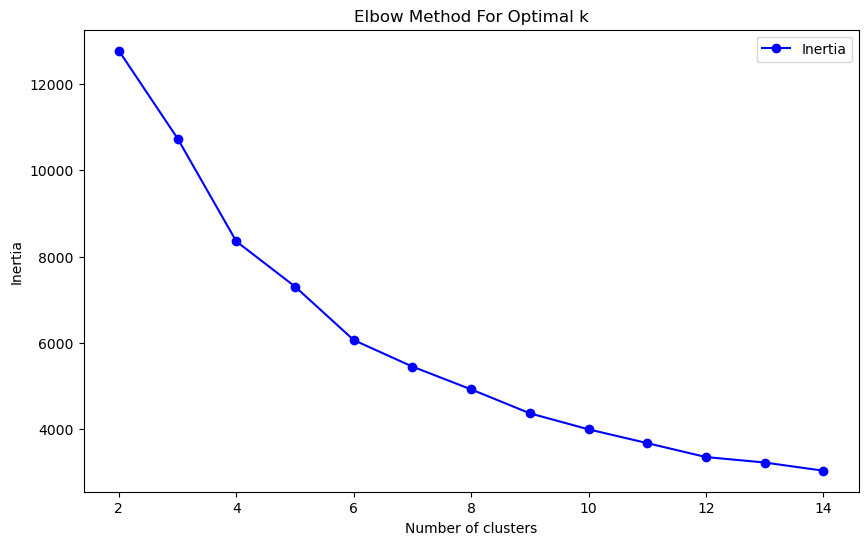

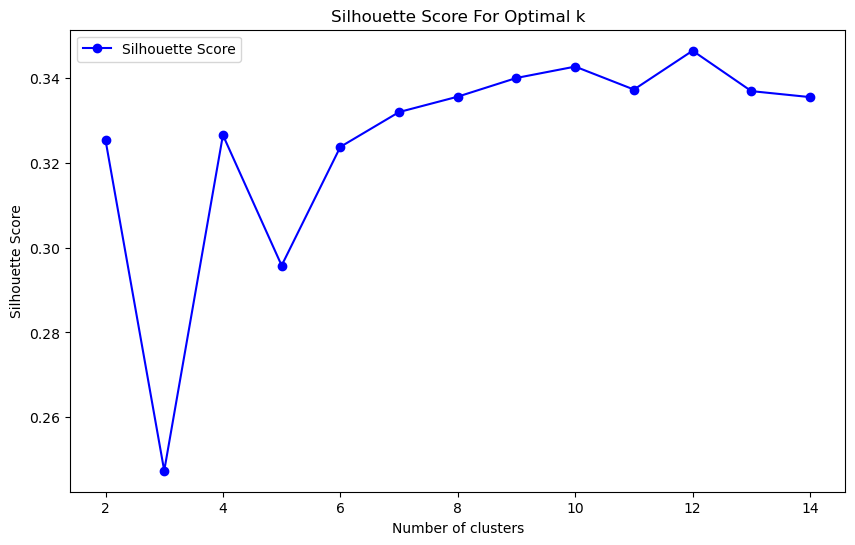

In [11]:
# Метод локтя для определения оптимального числа кластеров
inertia = []
silhouette_scores = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', label='Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

# Построение графика коэффициента силуэта
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.legend()
plt.show()

# Выбор оптимального числа кластеров и повторная кластеризация
optimal_k = 3  # Замените на выбранное оптимальное значение на основе графиков
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

#### Применение K-means на обучающей выборке

In [12]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_scaled)
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

#### Оценка кластеризации

In [13]:
sil_score_train = silhouette_score(X_train_scaled, train_clusters)
sil_score_test = silhouette_score(X_test_scaled, test_clusters)
print(f'Train Silhouette Score: {sil_score_train}')
print(f'Test Silhouette Score: {sil_score_test}')

Train Silhouette Score: 0.3354045595242816
Test Silhouette Score: 0.3448397316429011


#### Добавление кластеров к данным и сохранение данных для последующего анализа

In [14]:
clients['cluster'] = kmeans.predict(scaler.transform(X))
clients.to_csv('clients_features_with_clusters.csv', index=False)

#### Средние значения признаков для каждого кластера

In [15]:
cluster_analysis = clients.groupby('cluster').mean().reset_index()
print(cluster_analysis)

   cluster    client_id    gender        age  membership_duration  \
0        0  2091.796233  1.000000  28.381849          1203.654966   
1        1  1935.293224  0.000000  30.436916          1047.149241   
2        2  2080.081818  0.818182  30.047727          1091.206818   
3        3  2126.092326  0.998801  27.113909          1182.683153   
4        4  1926.181470  0.000000  26.851455          1179.880360   

   visit_count  fitness_category_count  total_visit_cost  \
0     1.147260                0.472603      1.140721e+06   
1    63.887850                2.456776      5.598075e+07   
2   134.861364                3.995455      7.789911e+07   
3    46.619904                2.685851      1.886487e+07   
4     9.709801                1.050536      4.474913e+06   

   fitness_category_crossfit  fitness_category_goboxing  \
0                   0.000000                   0.000000   
1                   0.193925                   0.855140   
2                   0.429545                   

#### Визуализация данных

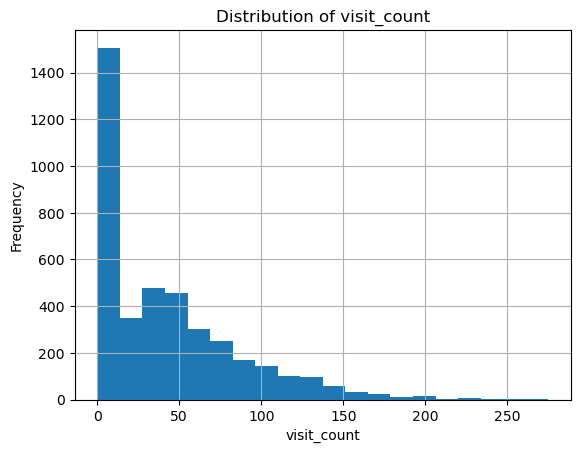

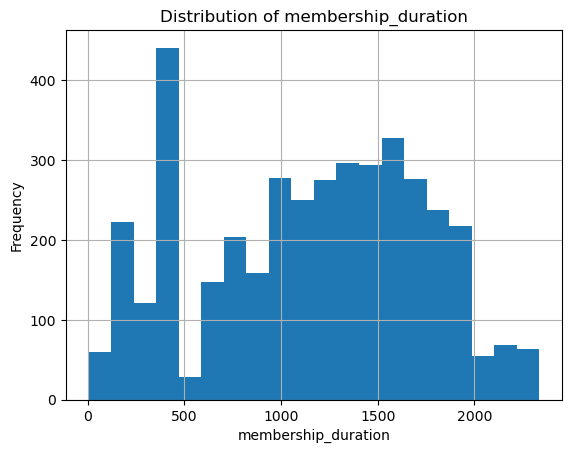

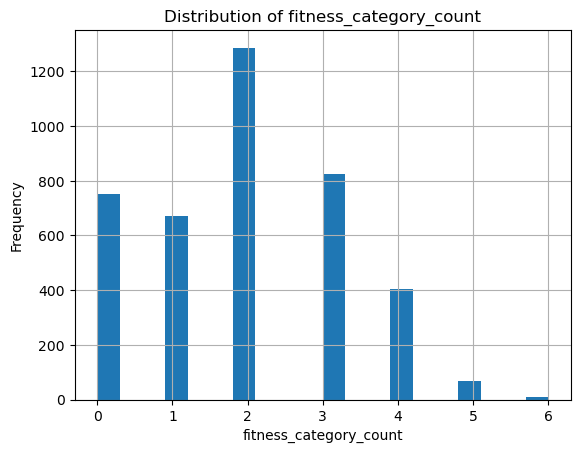

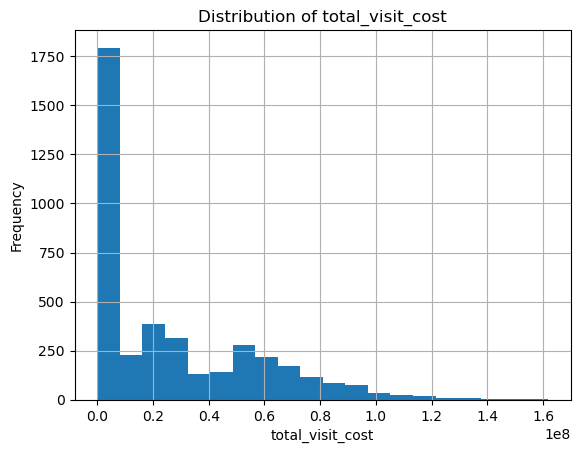

C:\Users\murzi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


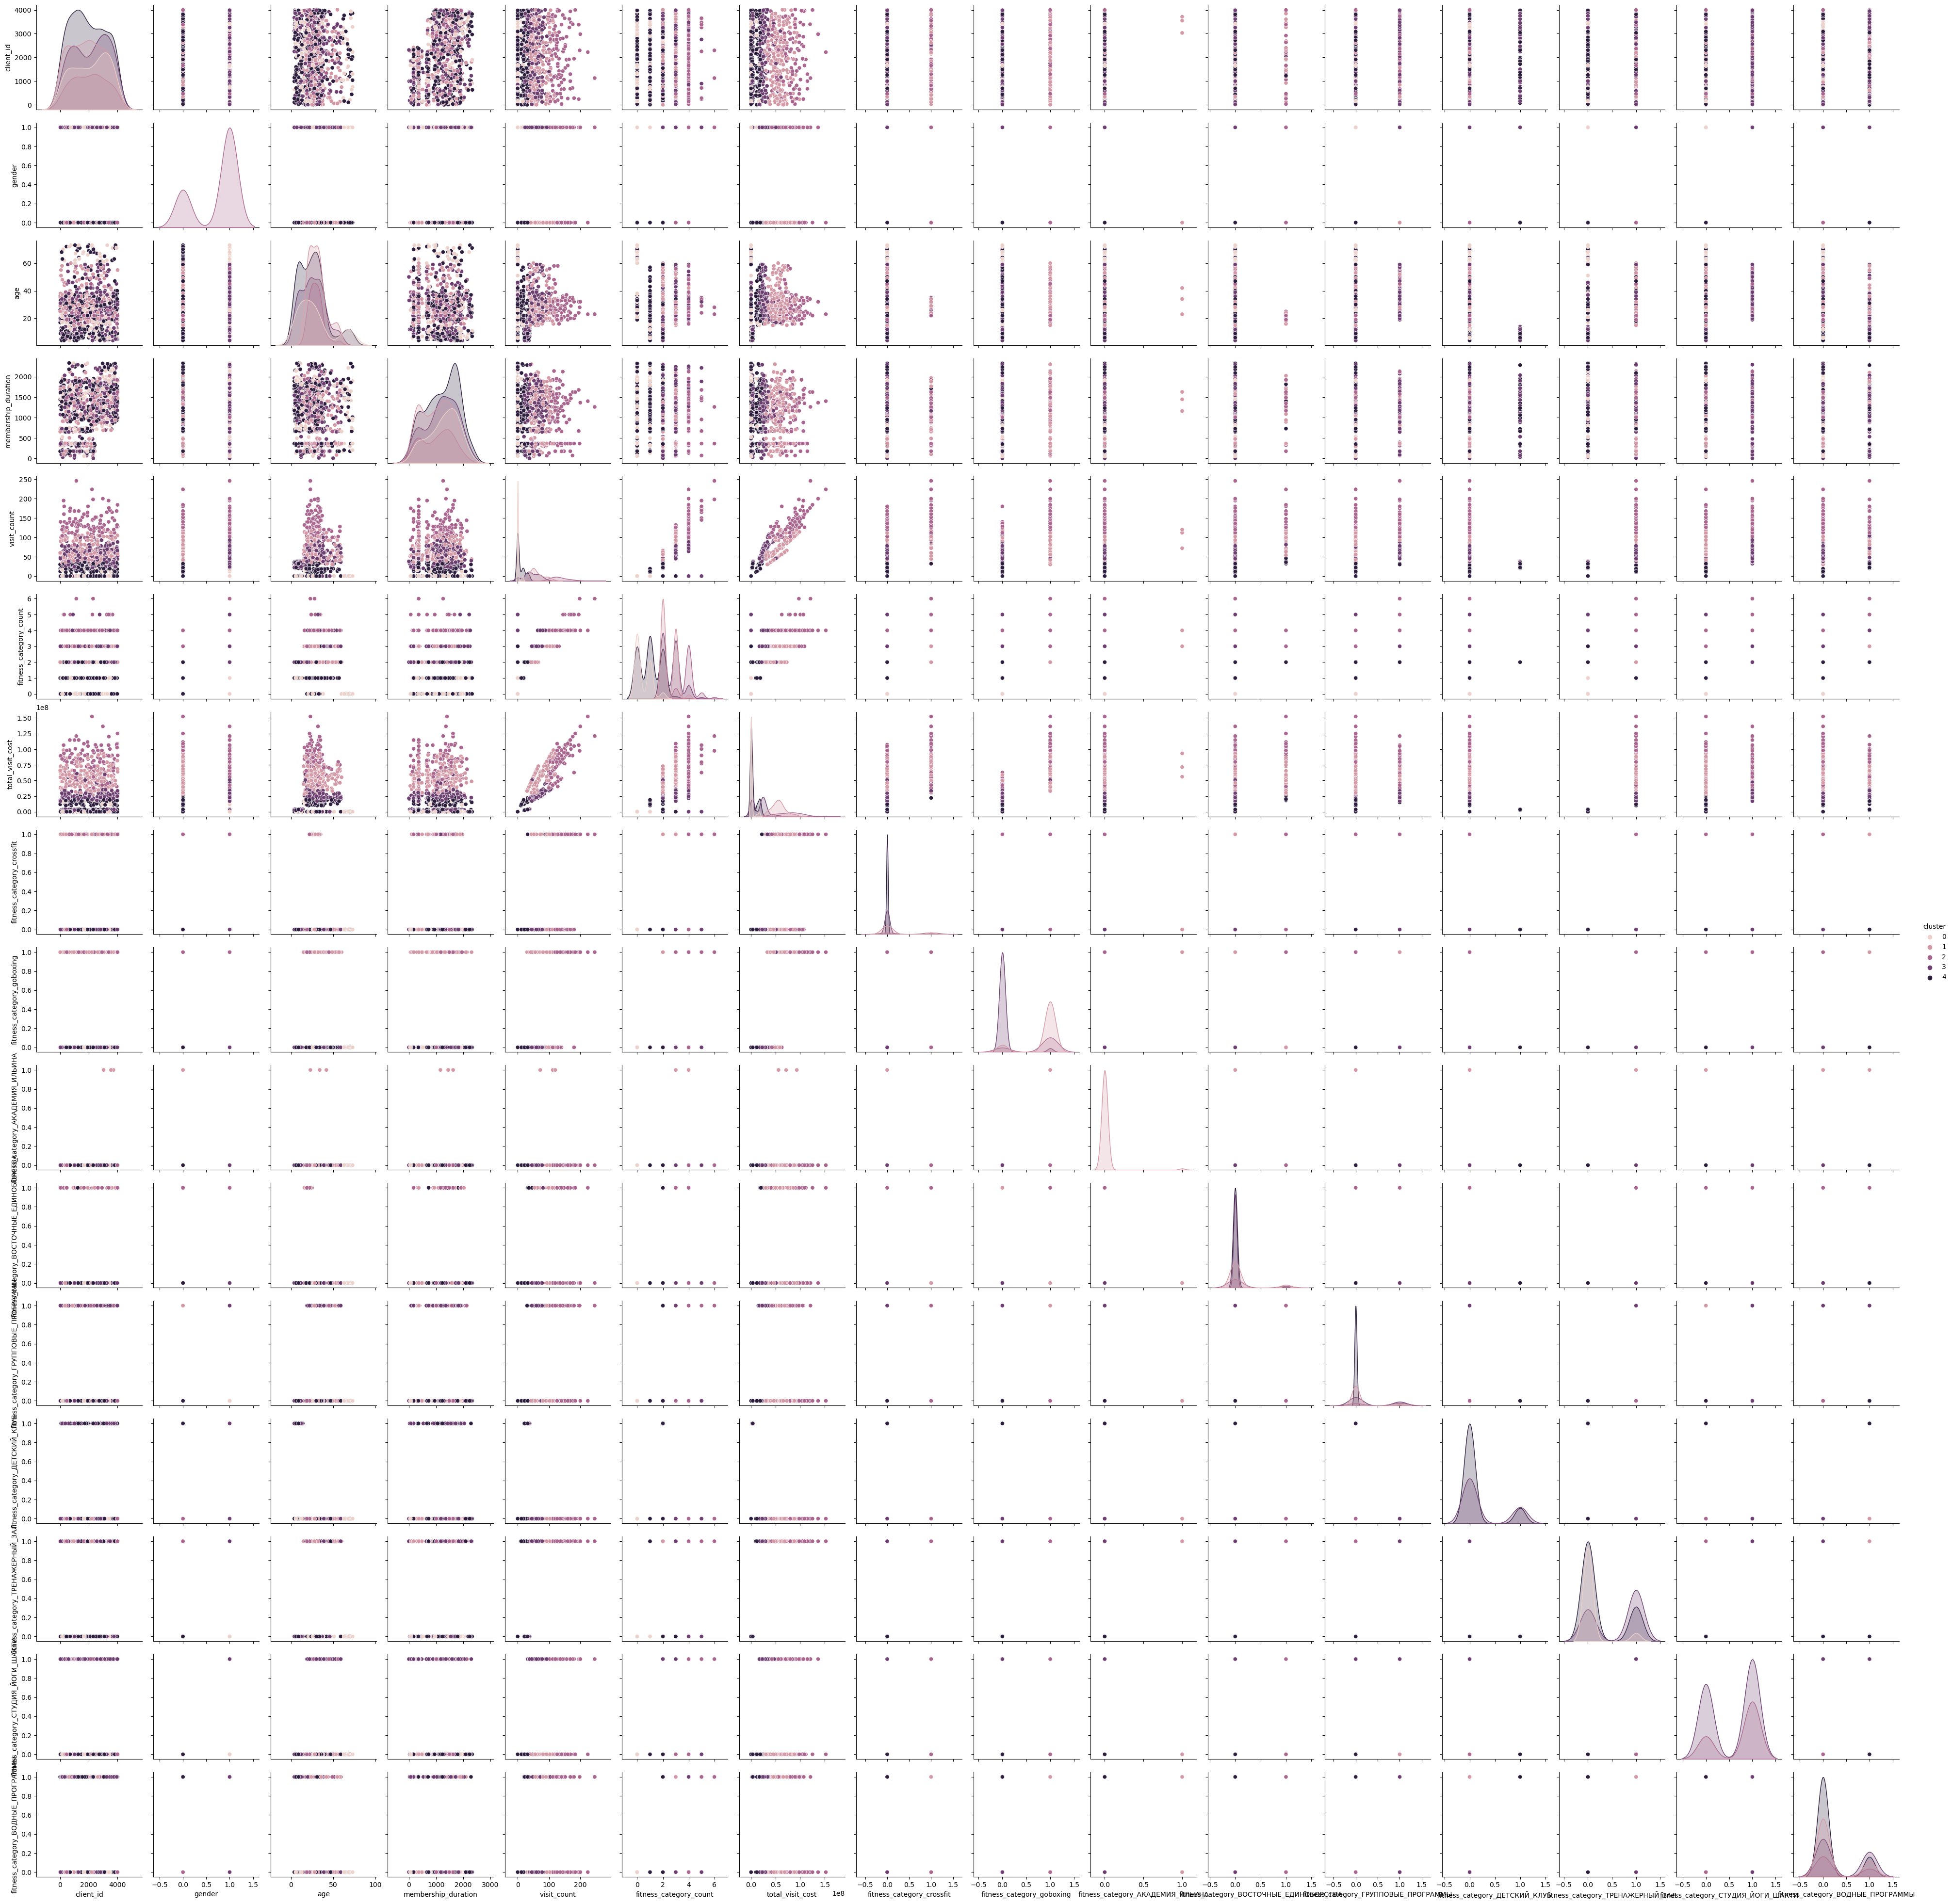

In [16]:
for feature in features[:-1]:  # без 'gender', так как он закодирован
    plt.figure()
    clients[feature].hist(bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

sample_data = clients.sample(1000)  # Если данных много, можно взять случайную выборку

sns.pairplot(sample_data, hue='cluster', diag_kind='kde')
plt.show()

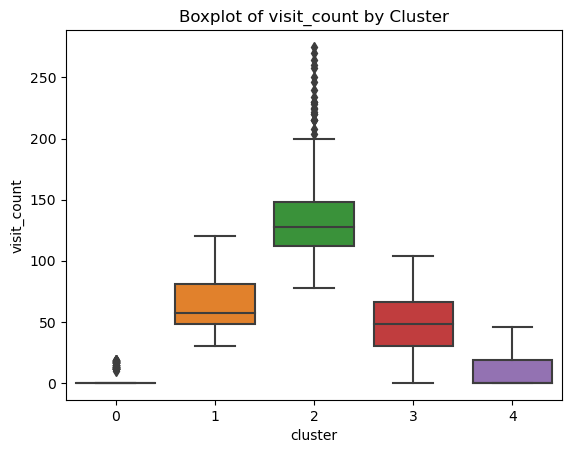

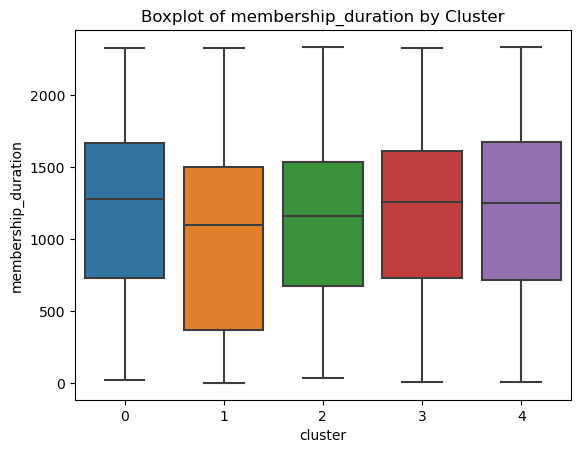

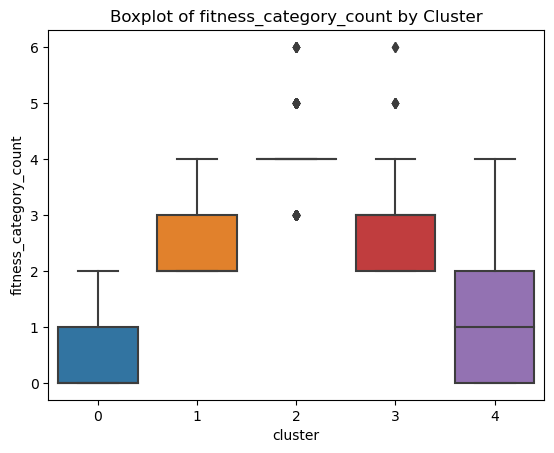

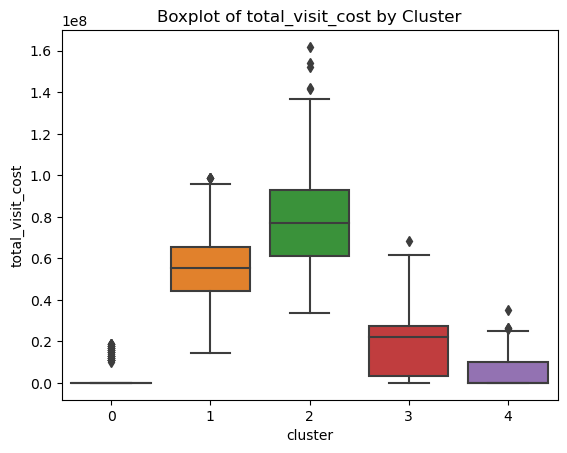

In [17]:
for feature in features[:-1]:  # без 'gender', так как он закодирован
    plt.figure()
    sns.boxplot(x='cluster', y=feature, data=clients)
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.show()

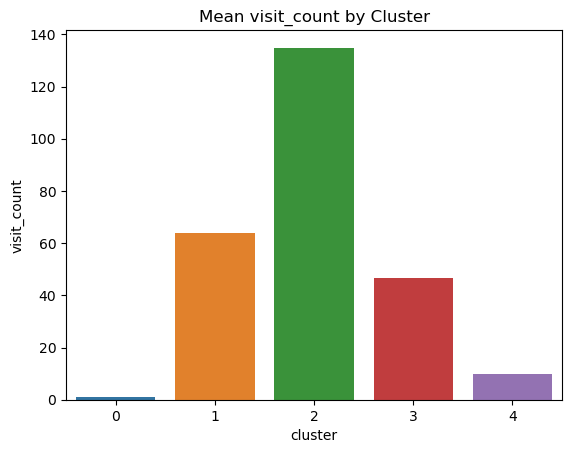

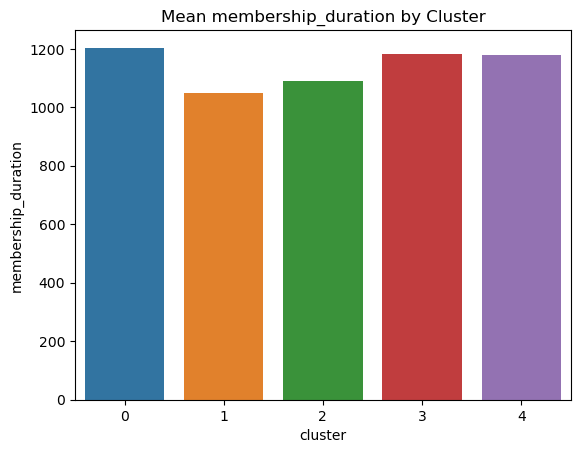

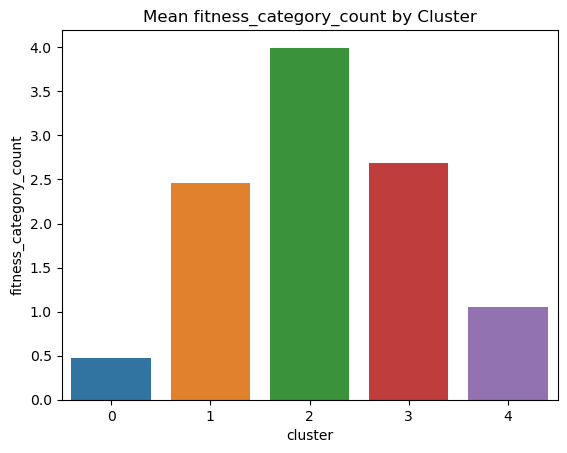

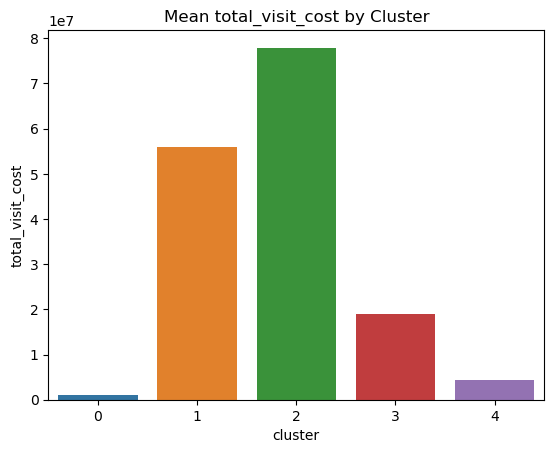

In [18]:
for feature in features[:-1]:  # без 'gender', так как он закодирован
    plt.figure()
    sns.barplot(x='cluster', y=feature, data=cluster_analysis)
    plt.title(f'Mean {feature} by Cluster')
    plt.show()

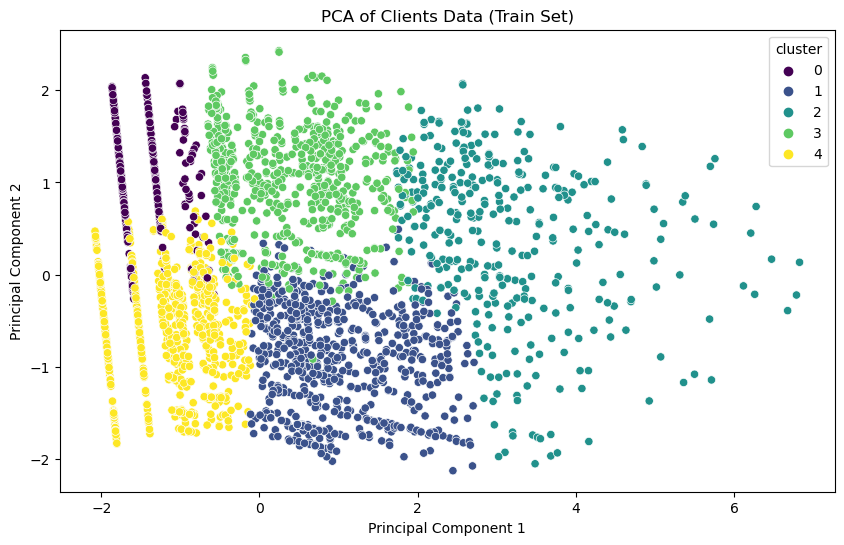

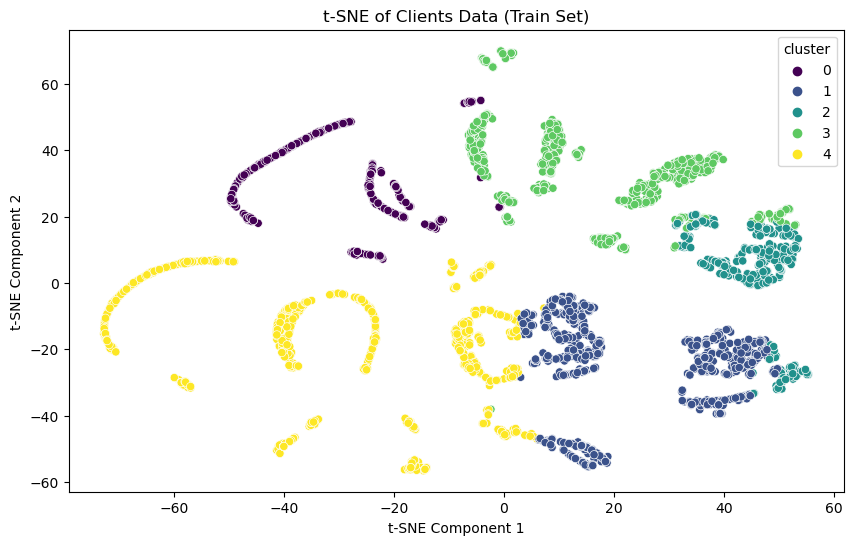

In [19]:
# Применение PCA для снижения размерности до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Создание DataFrame с результатами PCA и кластерами
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = train_clusters

# Визуализация кластеров на 2D графике
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=pca_df, palette='viridis')
plt.title('PCA of Clients Data (Train Set)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Применение t-SNE для снижения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

# Создание DataFrame с результатами t-SNE и кластерами
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = train_clusters

# Визуализация кластеров на 2D графике
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=tsne_df, palette='viridis')
plt.title('t-SNE of Clients Data (Train Set)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()